# Meme Stocks

## The Question

What happens when retail traders discover options on highly shorted stocks?

**Stocks analyzed:** GameStop (GME), AMC, BlackBerry (BB), Bed Bath & Beyond (BBBY), and others from the 2021 meme stock frenzy.

**Key metrics we're tracking:**
- Options activity relative to shares outstanding
- Volume patterns in calls vs puts  
- How options trading compares to stock trading

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (9,5)
plt.rcParams['font.size'] = 11
plt.rcParams['legend.fontsize'] = 11

In [ ]:
FILENAME = '../data/meme_stocks.xlsx'
SHEET = 'meme stock data'
ts = pd.read_excel(FILENAME, sheet_name=SHEET, header=[0, 1], index_col=0)
ts.tail().style.format('{:.1f}').format_index('{:%Y-%m-%d}')

---

# Options Activity: The Scale of the Phenomenon

## How Big Is the Options Market?

We're measuring **open interest** (total outstanding option contracts) as a percentage of shares outstanding.

In [ ]:
SHARES_PER_CONTRACT = 100
SCALE_BB_SHARES_OUT = 1e6
open_call = ts.xs('OPEN_INT_TOTAL_CALL', axis=1, level=1)
open_put = ts.xs('OPEN_INT_TOTAL_PUT', axis=1, level=1)
sh_out   = ts.xs('EQY_SH_OUT',         axis=1, level=1)
open_call_pct = open_call.mul(SHARES_PER_CONTRACT).div(sh_out.mul(SCALE_BB_SHARES_OUT))
open_put_pct = open_put.mul(SHARES_PER_CONTRACT).div(sh_out.mul(SCALE_BB_SHARES_OUT))

### Call option open interest as ratio of shares outstanding.

Do any of these stocks have more call option open interest than shares outstanding?


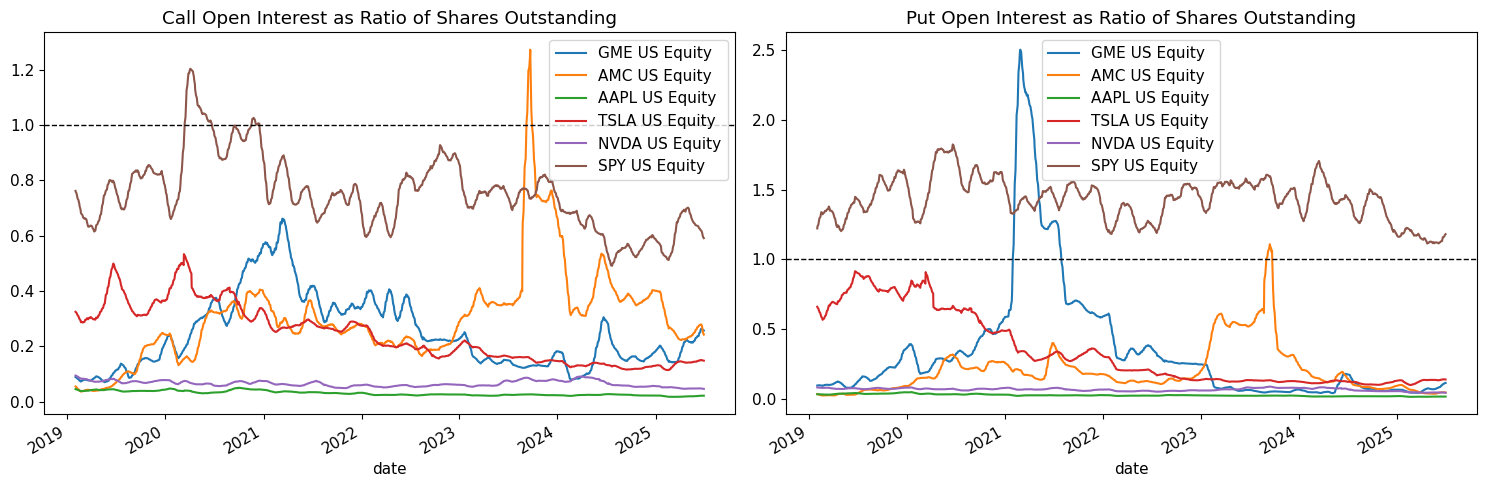

In [ ]:
WINDOW = 21

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Call options plot
open_call_pct.dropna().rolling(WINDOW).mean().plot(ax=axes[0], title='Call Open Interest as Ratio of Shares Outstanding')
axes[0].axhline(y=1, color='black', linestyle='--', linewidth=1)

# Put options plot  
open_put_pct.dropna().rolling(WINDOW).mean().plot(ax=axes[1], title='Put Open Interest as Ratio of Shares Outstanding')
axes[1].axhline(y=1, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

### Total Options Activity

**Combined calls + puts:** Shows the full scale of options open interest relative to the shares outstanding.


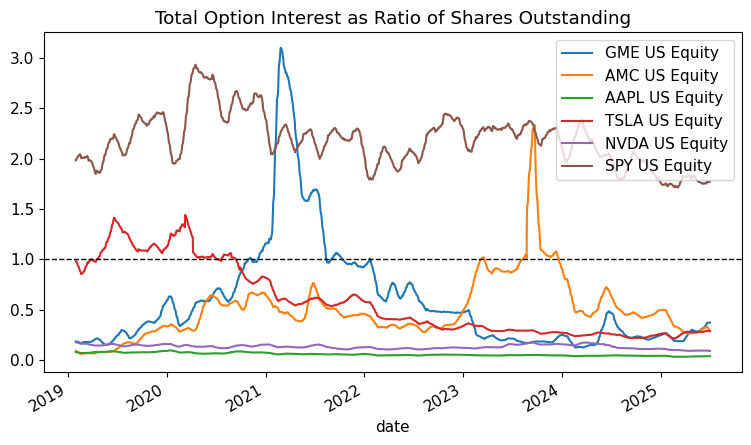

In [ ]:
open_opt_pct = open_call_pct + open_put_pct

ax = open_opt_pct.dropna().rolling(WINDOW).mean().plot(title='Total Option Interest as Ratio of Shares Outstanding')
ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
plt.show()

# Volumes

**Call Volume Ratio:** Call option volume as % of stock volume.

When this exceeds the 1% line, it means call option trading is unusually heavy relative to stock trading.


In [ ]:
WINDOW = 21

In [ ]:
FLDS = [
    'VOLUME',
    'VOLUME_TOTAL_CALL',
    'VOLUME_TOTAL_PUT'
]

volumes = ts.xs(FLDS[0], axis=1, level=1)
volumes_call = ts.xs(FLDS[1], axis=1, level=1)
volumes_put = ts.xs(FLDS[2], axis=1, level=1)

volume_c_pct = (volumes_call * SHARES_PER_CONTRACT / volumes).rolling(WINDOW).mean()
volume_p_pct = volumes_put * SHARES_PER_CONTRACT / volumes

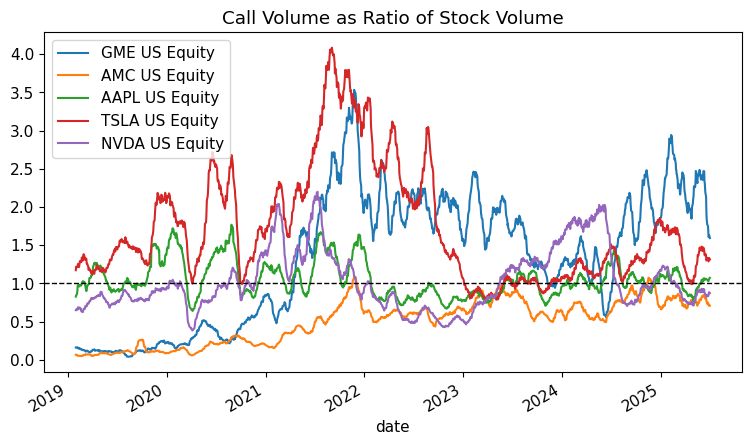

In [ ]:
ax = volume_c_pct.drop(columns=['SPY US Equity']).plot(title='Call Volume as Ratio of Stock Volume')
ax.axhline(y=1, color='black', linestyle='--', linewidth=1)
plt.show()

***

# Stock Prices

In [ ]:
import math
import matplotlib.pyplot as plt

def plot_field(ts, field, window=10,
               figsize=None, sharex=False, sharey=False):
    """
    Extract one field from a MultiIndex-ts DataFrame and plot each stock.

    Parameters
    ----------
    ts : pd.DataFrame
        Time-indexed DataFrame whose columns are a MultiIndex
        (level0=stock tickers, level1=fields).
    field : str
        The second-level field name to extract (e.g. 'volume', 'price', etc.).
    window : int, default=10
        Rolling window size for smoothing.
    figsize : tuple, optional
        Figure size; if None it defaults to (4*n, 3*n).
    sharex, sharey : bool, default=False
        Whether subplots share x-/y-axes.

    Returns
    -------
    fig, axes : matplotlib Figure and flattened Axes array
    """
    # 1) extract the field across all tickers
    try:
        df = ts.xs(field, axis=1, level=1)
    except KeyError:
        raise KeyError(f"Field {field!r} not found in ts.columns")

    # 2) set up grid
    tickers = df.columns.tolist()
    m = len(tickers)
    n = math.ceil(math.sqrt(m))
    fig, axes = plt.subplots(n, n,
                             figsize=figsize or (4*n, 3*n),
                             sharex=sharex,
                             sharey=sharey)
    axes = axes.flatten()

    # 3) pull the default color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # 4) loop & plot
    for i, (ax, ticker) in enumerate(zip(axes, tickers)):
        sm = df[ticker].rolling(window=window, min_periods=1).mean()
        ax.plot(sm.index, sm.values,
                color=colors[i % len(colors)])
        ax.axhline(1, linestyle='--', linewidth=1, color='black')
        ax.set_title(ticker)

    # 5) hide any unused axes
    for ax in axes[m:]:
        ax.set_visible(False)

    plt.tight_layout()
    return fig, axes


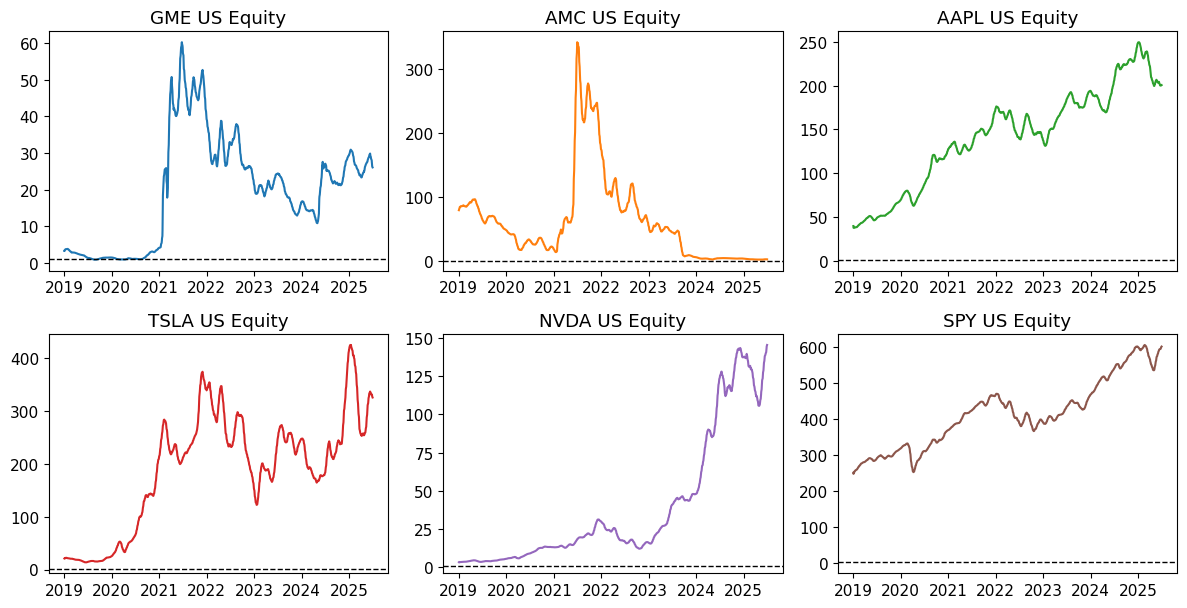

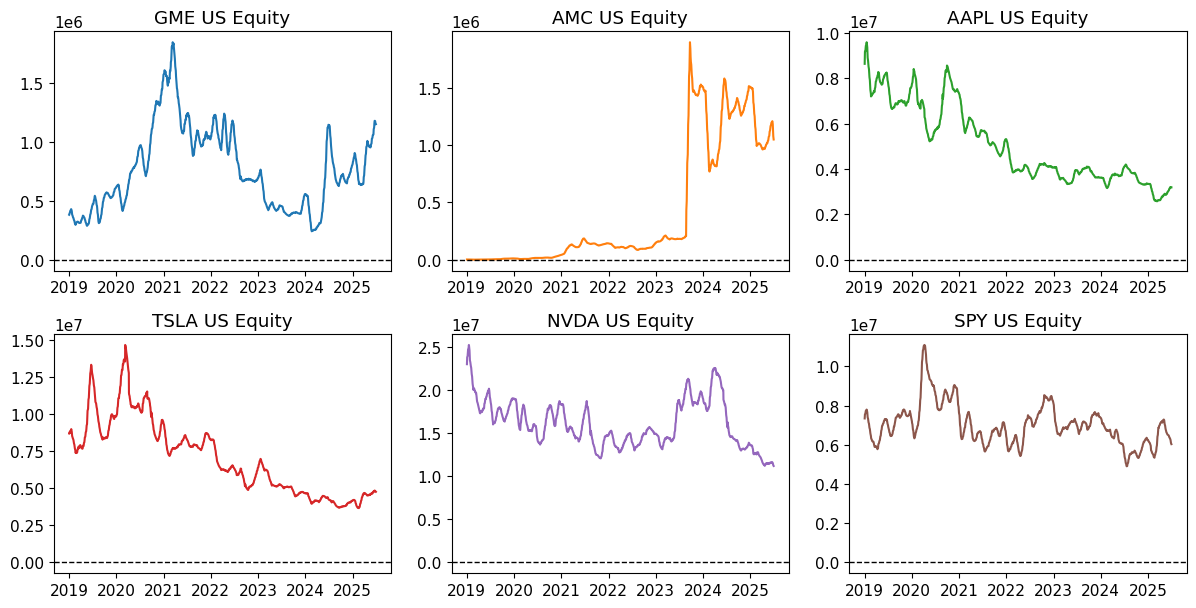

In [ ]:
FLD = 'PX_LAST'
fig, axes = plot_field(ts, FLD, window=WINDOW)
plt.show()

FLD = 'OPEN_INT_TOTAL_CALL'
fig, axes = plot_field(ts, FLD, window=WINDOW)
#plt.show()


## Stock Volume vs. Shares Outstanding

**Interpretation:** Higher ratios indicate unusually heavy trading relative to the company's share count.


In [ ]:
import math
import matplotlib.pyplot as plt

def plot_field_ratio(ts, num_field, den_field,
                     window=10, scale=1.0,
                     figsize=None, sharex=False, sharey=False, do_hline=False):
    """
    For each ticker in `ts`, plot the rolling‐mean of
    scale * (ts[ticker, num_field] / ts[ticker, den_field]) on an n×n grid.

    Parameters
    ----------
    ts : pd.DataFrame
        Time‐indexed DataFrame with a 2‐level columns index
        (level0=ticker, level1=field).
    num_field : str
        The numerator field name (level1) to extract.
    den_field : str
        The denominator field name (level1) to extract.
    window : int, default=10
        Rolling window size for smoothing.
    scale : float, default=1.0
        Constant to multiply the raw ratio by.
    figsize : tuple, optional
        Figure size; default = (4⋅n, 3⋅n).
    sharex, sharey : bool, default=False
        Whether to share x or y axes across subplots.

    Returns
    -------
    fig, axes : matplotlib Figure and flattened Axes array
    """
    # extract numerator & denominator
    try:
        num_df = ts.xs(num_field, axis=1, level=1)
    except KeyError:
        raise KeyError(f"Numerator field {num_field!r} not in ts.columns")
    try:
        den_df = ts.xs(den_field, axis=1, level=1)
    except KeyError:
        raise KeyError(f"Denominator field {den_field!r} not in ts.columns")

    # form scaled ratio
    ratio = (num_df / den_df) * scale

    # grid setup
    tickers = ratio.columns.tolist()
    m = len(tickers)
    n = math.ceil(math.sqrt(m))
    fig, axes = plt.subplots(n, n,
                             figsize=figsize or (4*n, 3*n),
                             sharex=sharex, sharey=sharey)
    axes = axes.flatten()

    # color cycle
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # plot
    for i, (ax, tkr) in enumerate(zip(axes, tickers)):
        sm = ratio[tkr].rolling(window=window, min_periods=1).mean()
        ax.plot(sm.index, sm.values,
                color=colors[i % len(colors)])
        
        if do_hline:
            ax.axhline(1, linestyle='--', linewidth=1, color='black')

        ax.set_title(tkr)

    # hide extras
    for ax in axes[m:]:
        ax.set_visible(False)

    plt.tight_layout()
    return fig, axes


## Stock Volume vs. Call Open Interest

**What this shows:** How many shares trade relative to call option positions.

Lower ratios suggest options activity is very large compared to stock trading.


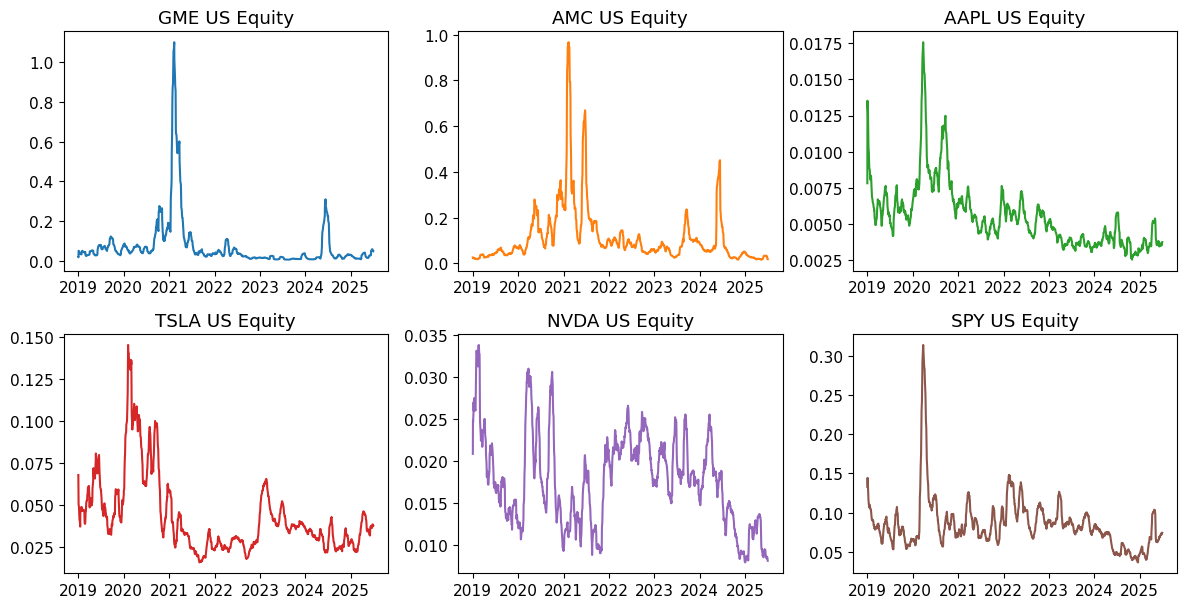

In [ ]:
fig, axes = plot_field_ratio(ts, 'VOLUME', 'EQY_SH_OUT', window=WINDOW,scale=1/1e6)
plt.show()


## Call vs. Put Volume Ratio

**Sentiment indicator:** Values above 1.0 show more call than put volume (bullish bias).

Meme stocks typically show very high call/put ratios during rallies.


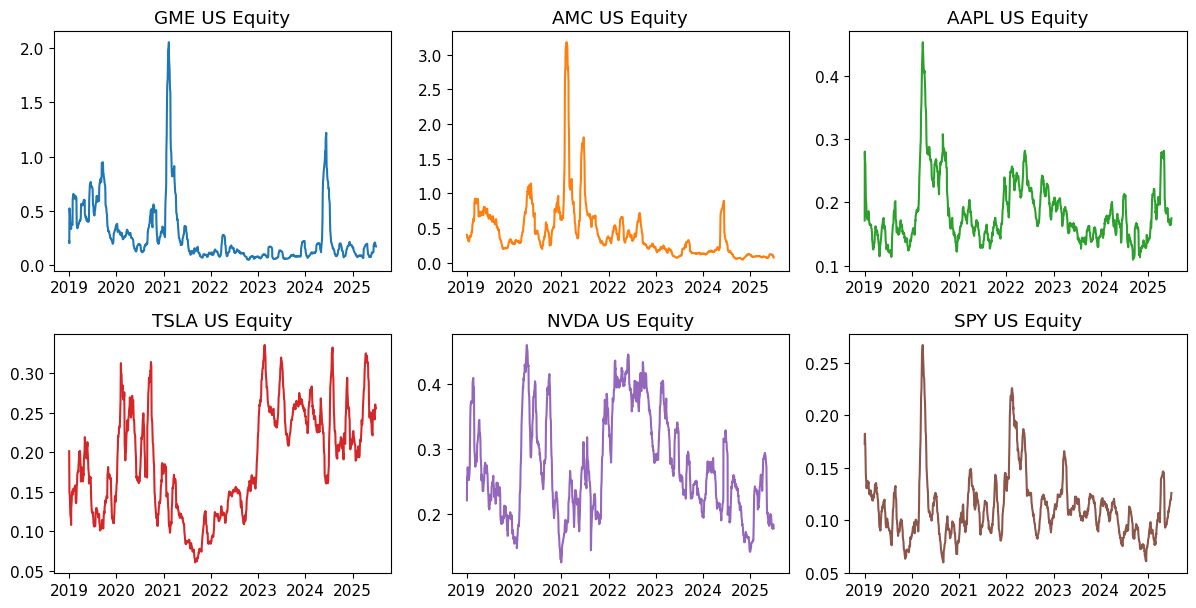

In [ ]:
fig, axes = plot_field_ratio(ts, 'VOLUME', 'OPEN_INT_TOTAL_CALL', window=WINDOW,scale=1/100)

## Call Volume as % of Stock Volume

**Scale of speculation:** When call volume exceeds 10-20% of stock volume, it indicates massive options speculation.


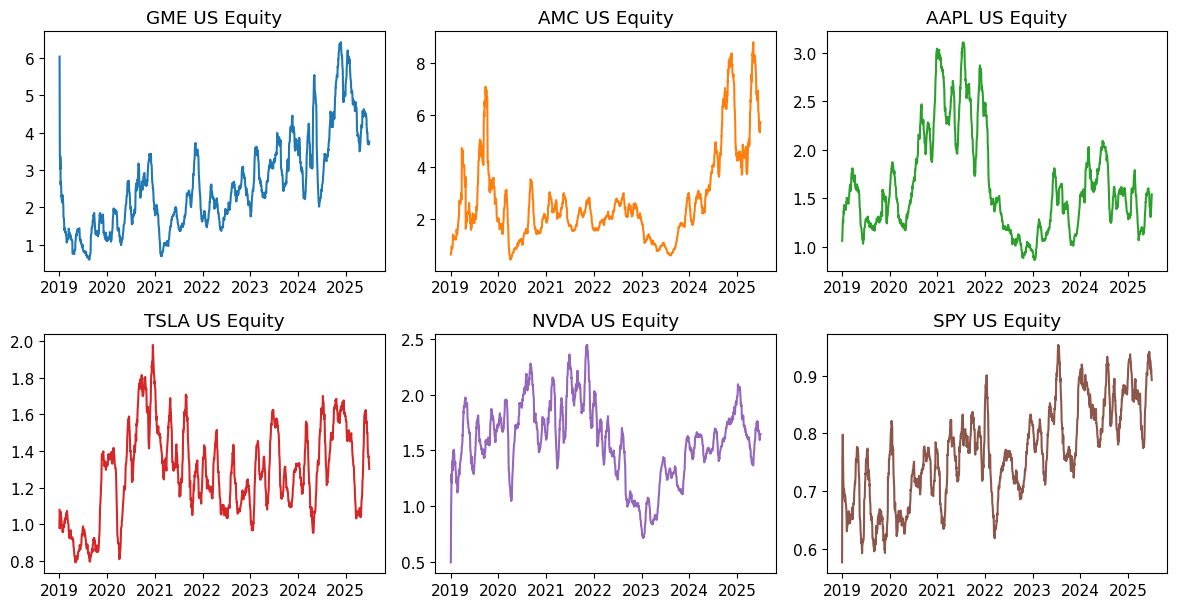

In [ ]:
fig, axes = plot_field_ratio(ts, 'VOLUME_TOTAL_CALL', 'VOLUME_TOTAL_PUT', window=WINDOW)

## Put Volume as % of Stock Volume

**Bearish activity:** Generally much lower than call volume for meme stocks - retail traders were primarily betting on upward moves.


# Extra Analysis


## Peak Options Activity Summary


In [ ]:
# Summary of peak options activity for each stock
summary_stats = pd.DataFrame()

# Peak call open interest as % of shares outstanding  
summary_stats['Peak Call OI %'] = open_call_pct.max()

# Peak put open interest as % of shares outstanding
summary_stats['Peak Put OI %'] = open_put_pct.max()

# Peak total options activity
summary_stats['Peak Total OI %'] = open_opt_pct.max()

# Peak call volume as % of stock volume
peak_call_vol = (volumes_call * 100 / volumes).max()
summary_stats['Peak Call Vol %'] = peak_call_vol

# Clean up and sort
summary_stats = summary_stats.round(2)
summary_stats = summary_stats.sort_values('Peak Total OI %', ascending=False)

print("Peak Options Activity by Stock:")
print("=" * 40)
summary_stats


Peak Options Activity by Stock:


Peak Call OI %  Peak Put OI %  Peak Total OI %  \
AMC US Equity             4.36           5.11             9.48   
TSLA US Equity            1.40           2.68             4.08   
GME US Equity             0.77           3.02             3.73   
SPY US Equity             1.37           1.97             3.11   
NVDA US Equity            0.11           0.09             0.20   
AAPL US Equity            0.07           0.07             0.14   

                Peak Call Vol %  
AMC US Equity              1.74  
TSLA US Equity             6.15  
GME US Equity              5.16  
SPY US Equity             13.07  
NVDA US Equity             3.85  
AAPL US Equity             5.79

## Options Activity vs. Price Volatility


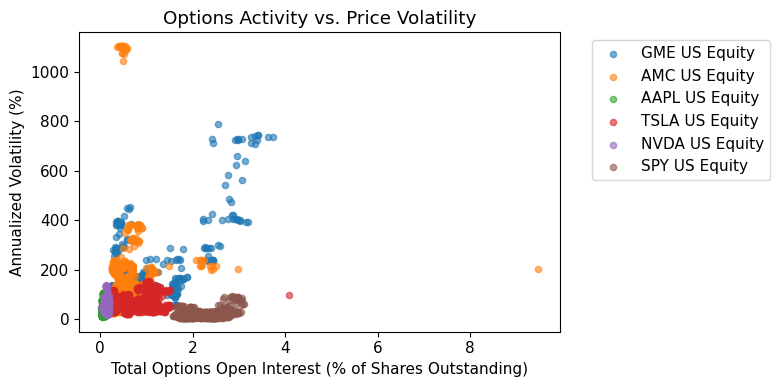

In [ ]:
# Calculate price volatility and compare with options activity
prices = ts.xs('PX_LAST', axis=1, level=1)
returns = prices.pct_change()
volatility = returns.rolling(WINDOW).std() * np.sqrt(252) * 100  # Annualized vol

# Create scatter plot of options activity vs volatility
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for stock in open_opt_pct.columns:
    if stock in volatility.columns:
        # Get data where both exist
        opt_data = open_opt_pct[stock].dropna()
        vol_data = volatility[stock].dropna()
        
        # Align the data
        common_dates = opt_data.index.intersection(vol_data.index)
        if len(common_dates) > 10:  # Only plot if we have enough data
            ax.scatter(opt_data[common_dates], vol_data[common_dates], 
                      alpha=0.6, label=stock, s=20)

ax.set_xlabel('Total Options Open Interest (% of Shares Outstanding)')
ax.set_ylabel('Annualized Volatility (%)')
ax.set_title('Options Activity vs. Price Volatility')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Key Takeaways

<div 
<h3>What Makes a Meme Stock?</h3>
<ul>
<li><strong>Massive options activity:</strong> Open interest often exceeds 5-10% of shares outstanding</li>
<li><strong>Bullish bias:</strong> Call volume dominates put volume by huge margins</li>
<li><strong>Retail-driven:</strong> Options volume can exceed 20%+ of stock volume during peaks</li>
<li><strong>High volatility:</strong> Options activity correlates with extreme price swings</li>
</ul>
</div>

**The 2021 meme stock phenomenon showed how options markets can amplify retail sentiment and create feedback loops between options activity and stock prices.**


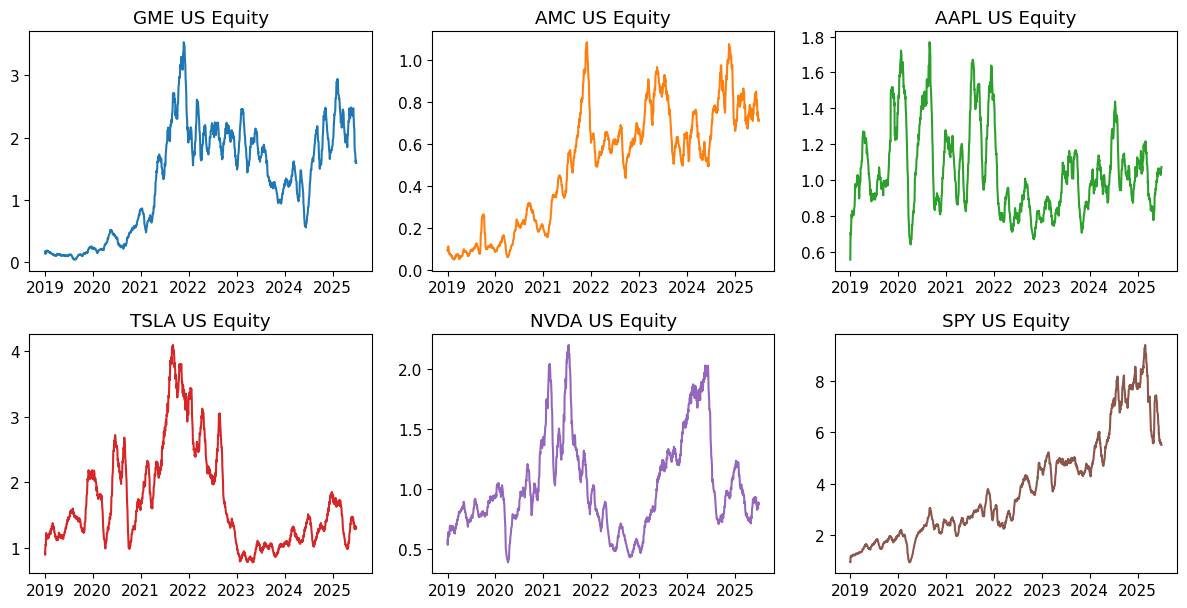

In [ ]:
fig, axes = plot_field_ratio(ts, 'VOLUME_TOTAL_CALL', 'VOLUME', window=WINDOW,scale=100)
plt.show()

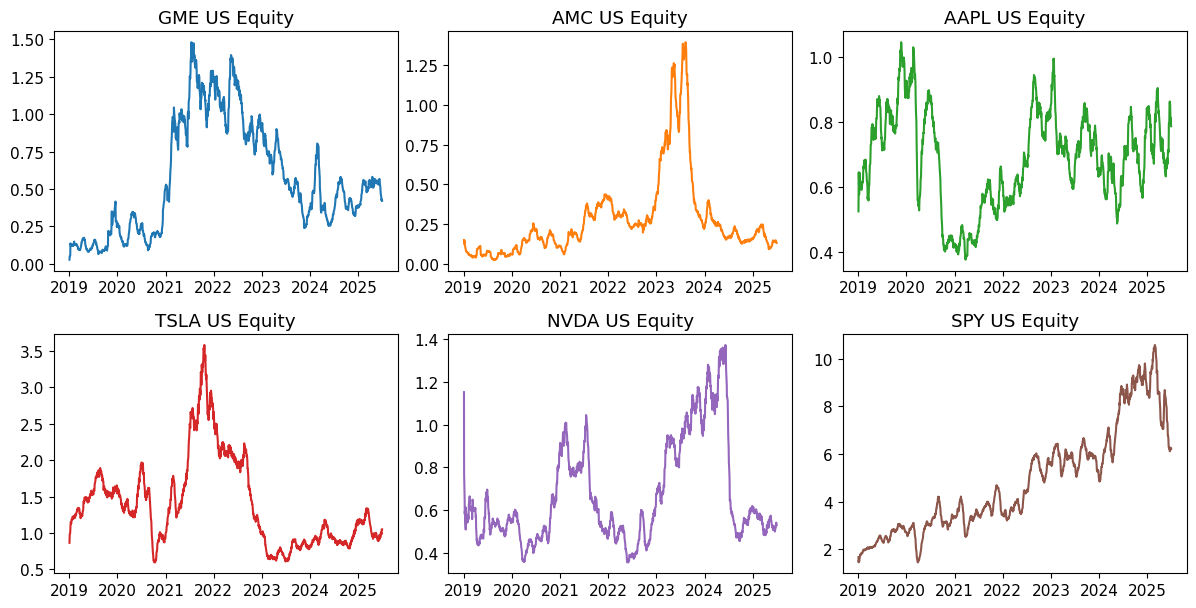

In [ ]:
fig, axes = plot_field_ratio(ts, 'VOLUME_TOTAL_PUT', 'VOLUME', window=WINDOW,scale=100)
plt.show()